In [23]:
from PIL import Image
import matplotlib.pyplot as plt

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from astropy.stats import sigma_clipped_stats
from astropy.visualization import astropy_mpl_style
from astropy.constants import R_sun, L_sun
from astropy.io import fits

from skimage import io, filters, measure
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from skimage.util import crop
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

import math
import numpy as np
import pandas as pd

import os

plt.style.use(astropy_mpl_style)

### Handling data

In [42]:
def im_brightness(data_array):

    brightness = 0.2126*arr[:,:,0] + 0.7152*arr[:,:,1] + 0.0722*arr[:,:,2] # Convert RGB to brightness plot

    """
    plt.imshow(brightness, origin='lower')
    plt.grid(False)
    plt.colorbar()
    plt.show()
    """
    
    return brightness

### Image segmentation to locate and characterise the star

In [5]:
def im_segmentation(data_array):
    
    # Convert the image to grayscale
    image_gray = rgb2gray(arr)

    # Compute the threshold value for object detection
    threshold = filters.threshold_otsu(image_gray)

    # Perform image segmentation to identify the individual objects in the image
    label_image = label(image_gray >= threshold)
    
    # Uncomment to plot image segmentation
    #plt.imshow(label_image, origin='lower')

    # Extract the properties of the objects detected in the image
    target = regionprops(label_image)

    props = regionprops_table(label_image, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
    
    df = pd.DataFrame(props)
    
    return df

### Ring Background Photometry

In [95]:
def RBP_plot(brightness_data, segmentation):
    
    # Define the circular aperture
    position = (segmentation.loc[0, 'centroid-1'], segmentation.loc[0, 'centroid-0'])
    aperture_radius = (segmentation.loc[0, 'axis_major_length']+segmentation.loc[0, 'axis_minor_length'])/4
    aperture = CircularAperture(position, aperture_radius)

    fig, ax = plt.subplots()
    ax.imshow(brightness_data, origin='lower')

    # Draw the aperture and annulus on the axis
    aperture = plt.Circle(position, aperture_radius, color='darkorange', fill=False)
    annulus_inner = plt.Circle(position, aperture_radius + 5.0, color='cyan', fill=False)
    annulus_outer = plt.Circle(position, aperture_radius + 10.0, color='cyan', fill=False)
    ax.add_artist(aperture)
    ax.add_artist(annulus_inner)
    ax.add_artist(annulus_outer)

    # Show the plot
    plt.show()
    
    

In [89]:
def RBP_flux(brightness_data, segmentation):
    
    # Define the circular aperture
    position = (segmentation.loc[0, 'centroid-1'], segmentation.loc[0, 'centroid-0'])
    aperture_radius = (segmentation.loc[0, 'axis_major_length']+segmentation.loc[0, 'axis_minor_length'])/4
    aperture = CircularAperture(position, aperture_radius)

    # Extract the pixel values within the aperture
    phot_table = aperture_photometry(brightness, aperture)

    # Compute the total flux within the aperture
    flux = phot_table['aperture_sum'][0]

    # Compute the mean background level within an annulus around the star
    inner_annulus_radius = aperture_radius + 10.0
    outer_annulus_radius = aperture_radius + 20.0
    annulus_aperture = CircularAnnulus(position, inner_annulus_radius, outer_annulus_radius)
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(brightness)
    background_mean = annulus_data.mean()

    # Compute the background-subtracted flux
    flux_subtracted = flux - background_mean
    
    return flux_subtracted

### Luminosity

In [90]:
sun_l = 3.8*(10)**26 # W
theoretical_l = 80*sun_l

r_sun = 696340000 # m
r1 = 12*r_sun # radius of the star
r2 = 43*9.5*10**15 #m

print('With r = radius of the star', 4*math.pi*(r1**2)*RBP_flux(brightness, segmented))
print('')

print('With r = distance between star and the earth', 4*math.pi*(r2**2)*RBP_flux(brightness, segmented))
print('')

With r = radius of the star 1.1625264566617829e+26

With r = distance between star and the earth 2.77831695096089e+41



In [91]:
# TODO: Get the real constants with “from astropy.constants import R_earth, c”
# TODO: Figure out which radius to use for the luminosity
# TODO: Compare Exp. to Theo. of Capella to get the scaling factor needed to apply to Algol

### Capella

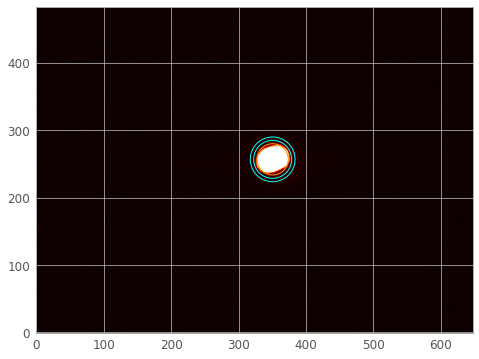

Star: Capella
Corrected Flux (mean):  400535.97947362607
Standard deviation:  48960.67143221879


In [96]:
path = 'CCD-images/04-04-23/capella'

capella = os.listdir(path)

capella_f = np.zeros(len(capella))

for i in range(len(capella)):
    # Open the BMP image file
    data = Image.open(path + '/' + capella[i])
    
    # Convert the image to a numpy array
    arr = np.array(data)
    
    brightness = im_brightness(arr)
    
    segmented = im_segmentation(arr)
    
    if i==1:
        RBP_plot(brightness, segmented)
    
    #print(i)
    #print(RBP_flux(brightness, segmented))
    
    capella_f[i] = RBP_flux(brightness, segmented)
    
print('Star: Capella')
print('Corrected Flux (mean): ', np.mean(capella_f))
print('Standard deviation: ', np.std(capella_f))

### Algol

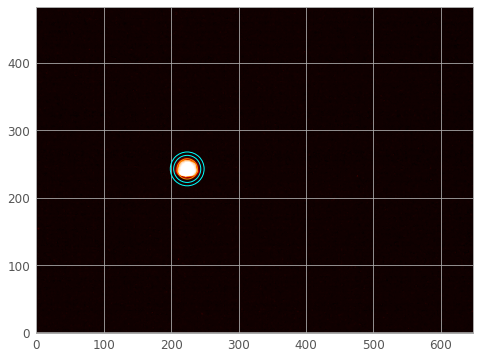

Star: Algol
Corrected Flux (mean):  196492.2756711979
Standard deviation:  39253.4258851381


In [97]:
path = 'CCD-images/04-04-23/algol'

algol = os.listdir(path)

algol_f = np.zeros(len(algol))

for i in range(len(algol)):
    # Open the BMP image file
    data = Image.open(path + '/' + algol[i])
    
    # Convert the image to a numpy array
    arr = np.array(data)
    
    brightness = im_brightness(arr)
    
    segmented = im_segmentation(arr)
    
    if i==1:
        RBP_plot(brightness, segmented)
    
    algol_f[i] = RBP_flux(brightness, segmented)    
    
print('Star: Algol')
print('Corrected Flux (mean): ', np.mean(algol_f))
print('Standard deviation: ', np.std(algol_f))

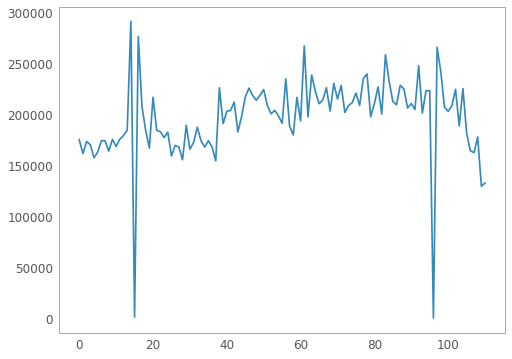

In [94]:
plt.plot(algol_f)
plt.grid(False)
plt.show()